# Text Classification with word embeddings
This notebook explores GloVe word embeddings and its use in text classification.

First, the embedding space is explored by looking at word embeddings and the relation between distance and semantic meaning in the embedding space.

Then, different classifiers are implemented to predict what a document (short paragraph) is talking about. The dataset that will be used in this notebook contains annotated text excerpts, already pre-split into train/validation/test sets.
| <p style="text-align: center;">Subset</p>  | <p style="text-align: center;">Number of Samples</p> | <p style="text-align: center;">Proportion (%)</p> |
| ---------------------------------------------- | ---------------------------------------------- | ---------------------------------------------- |
| <p style="text-align: left">Train</p>| <p style="text-align: left">12110</p> | <p style="text-align: left">70</p> | 
| <p style="text-align: left">Validation</p>| <p style="text-align: left">2596</p> | <p style="text-align: left">15</p> |
| <p style="text-align: left">Test</p>| <p style="text-align: left">2595</p> | <p style="text-align: left">15</p> |

The input to the classification is a sentence embedding (average GloVe embedding of all words in the document) and the output is one of 12 labels.

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import os
from IPython.display import display_html

#Sklearn libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Plotting libraries
import matplotlib.pyplot as plt

# Constants
OOV_TOKEN = "[oov]"

# PyTorch libraries
import torch
from torch.utils.tensorboard import SummaryWriter

%load_ext autoreload
%autoreload 2

c:\Users\hecto\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Colab data management
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    _home = 'gdrive/MyDrive/'
except ImportError:
    #_home = '~/'
    _home = os.getcwd()


# load the train, validation, and test datasets
path = "datasets/"

#-20230115-105638/thedeep.
path = os.path.join(_home, path)
assert os.path.exists(path), path

# check if pickle folder exists, if not create one
pickle_folder = "pickle_preprocessed_data"

if not os.path.exists(os.path.join(path, pickle_folder)):
    os.mkdir(os.path.join(path, pickle_folder))

# define path to datasets
data_path = os.path.join(path, "-20230115-105638")
assert os.path.exists(data_path), data_path
print(data_path)

# define path to pickled folder
pickle_path = os.path.join(path, pickle_folder)
assert os.path.exists(pickle_path), pickle_path
print(pickle_path)

# define path to glove embeddings
# glove_path = os.path.join(path, "glove.6B.50d.txt")
# assert os.path.exists(glove_path), glove_path

# pytorch model paths
model_path = os.path.join(pickle_path, "bestmodel")
print(model_path)

# seed for reproducibility
torch.manual_seed(1806)
torch.cuda.manual_seed(1806)

# check if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

c:\Users\hecto\Documents\ai\nlp\embedding_classifier\datasets/-20230115-105638
c:\Users\hecto\Documents\ai\nlp\embedding_classifier\datasets/pickle_preprocessed_data
c:\Users\hecto\Documents\ai\nlp\embedding_classifier\datasets/pickle_preprocessed_data\bestmodel
cpu


## GloVe Exploration
First we load in the GloVe embeddings as a dictionary. Glove has embeddings for 40 000 words which are represented by 50,100,200 or 300 features depending on which GloVe model is used. We create an empty dictionary and go through GloVe, extracting each word and its embedding.

In [3]:
from Embeddings import get_glove_embeddings,knn

In [4]:
glove_embeddings = get_glove_embeddings(50)

### Distance in the embedding space
Now we look at the distances between words in the embedding space. If the model has learned good representations for words, distance between words in the space reflects "semantic distance", i.e. similar words are closer to each other, and dissimilar words are farther away from each other. We will measure the proximity of two words with Cosine similarity.

Let us inspect the word "king" and compare it to the words "queen","throne","basil","sock" and "quantum".

In [5]:
# test the embeddings by taking a word and comparing it with (dis)similar words in the embedding space
distances = {"king" : ["queen","throne","basil","sock","quantum"]}

# create an empty df for the similarity table thingy
table = pd.DataFrame(columns = ["Source word","target word","cosine similarity"])

# loop over the dictionary containing the source words and their target words
for source_word in distances:
    # loop over the current source word's target words
    for index,target_word in enumerate(distances[source_word]):

        # calculate the cosine similarity between the source word and the target word
        cosine_similarity = np.dot(glove_embeddings[source_word],glove_embeddings[target_word]) / (np.linalg.norm(glove_embeddings[source_word]*np.linalg.norm(glove_embeddings[target_word])))
        
        # insert the current entry
        table.loc[-1] = [source_word,target_word,cosine_similarity]
        
        # add an index & sort by index (to be able to keep adding new rows)
        table.index = table.index + 1
        table = table.sort_index()

#
table = table.sort_index(ascending=False)


display(table)

,Source word,target word,cosine similarity
4,king,queen,0.783904
3,king,throne,0.753991
2,king,basil,0.310410
1,king,sock,0.104274
0,king,quantum,0.017817


### Nearest neighbors
Now we will explore the nearest neighbors of words in the embedding space. We will do this by defining a source word and a distance metric (Cosine similarity / Dot product), and identifying the top-k words closest to the source word

In [6]:
source_word = "cortical"
knn_table_cos = knn(source = source_word,embedding = glove_embeddings, distance = "cosine",k = 10)
knn_table_cos = knn_table_cos.sort_index(ascending=False)

knn_table_dot = knn(source = source_word,embedding = glove_embeddings, distance = "dot",k = 10)
knn_table_dot = knn_table_dot.sort_index(ascending=False)

In [7]:
cos_styler = knn_table_cos.style.set_table_attributes("style='display:inline'").set_caption('Cosine Similarity')
dot_styler = knn_table_dot.style.set_table_attributes("style='display:inline'").set_caption('Dot Product')

display_html(cos_styler._repr_html_()+dot_styler._repr_html_(), raw=True)

,word,similarity
10,cortical,1.000000
9,hippocampal,0.828183
8,cerebellum,0.790318
7,hippocampus,0.779940
6,cortex,0.770618
5,sensory,0.764024
4,neuronal,0.762305
3,neurons,0.759586
2,subcortical,0.750654
1,retinal,0.744135


## Classification
Now we will train a classifier for predicting the class of a given document. The classification will follow the following workflow:
>1. Read in the data and preprocess it by removing punctuations and numbers, transforming to lowercase and tokenizing each document (word-based tokenization)

>2. Define a vocabulary of tokens to be used in the classification. To ensure better generalizability, we will only include tokens/words that attain a certain frequency threshold (a word has to occur at least 100 times in the dataset to be considered relevant)

>3. Map our vocabulary of tokens to word embeddings

>4. Define a document embedding by taking the average over all embeddings in the document. This results in an embedding that represents the meaning of the entire document.

>5. Train multiple classifiers on the document embeddings

In [8]:
from Preprocessing import remove_punctuations, to_lower, remove_numbers, tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hecto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hecto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Create a dictionary for the data sets
data_dict = {
    "train" : None,
    "test" : None,
    "validation" : None
    }

# loop over datasets, apply preprocessing and pickle
for key, df in data_dict.items():

    try:
        # if already pickled, just read in
        df = pd.read_pickle(f"{pickle_path}/{key}.pkl")
        data_dict[key] = df
        print(f"{key} loaded from pickle")

    except:
        # if not pickled, preprocess and pickle
        print(f"dataset '{key}' does not exist, preprocessing and pickling")

        # Read in data
        print("reading")
        df = pd.read_csv(f"{data_path}/thedeep.subset.{key}.txt",names=["id", "text", "label"] , header=None)

        # Preprocess
        print("preprocessing")
        df["cleaned_text"] = df["text"].apply(remove_punctuations).apply(to_lower).apply(remove_numbers)

        # tokenize
        print("tokenizing")
        df["tokens"] = df["cleaned_text"].apply(tokenize)

        # Pickle and insert into dictionary
        print("pickling")
        df.to_pickle(f"{pickle_path}/{key}.pkl")
        data_dict[key] = df
    
# insert the labels into the data dictionary
data_dict["label_encoding"] = pd.read_csv(f"{data_path}/thedeep.labels.txt", names = ["label"], usecols = [1], header = None)


train loaded from pickle
test loaded from pickle
validation loaded from pickle


### Vocabulary
Now we will define our vocabulary of words to be used in the classification. We will reduce our vocabulary size by discarding tokens that are infrequent. A word has to occur at least 100 times in the dataset to be considered relevant enough. Words with fewer occurences will become OOV tokens (token = "[oov]")

In [10]:
from Preprocessing import token_counts,embeddings_to_words

In [11]:
df_train = data_dict["train"]
df_test  = data_dict["test"]
df_validation = data_dict["validation"]

dictionary = token_counts(df_train, "[oov]", thresh = 100)
dictionary

,index,tokens
0,cases,4757
1,food,4138
2,people,3796
3,reported,3676
4,children,2894
...,...,...
948,nearby,100
949,threat,100
950,established,100
951,cooking,100


In [12]:
df_train

,id,text,label,cleaned_text,tokens
0,5446,In addition to the immediate life-saving inter...,9,in addition to the immediate lifesaving interv...,"[addition, immediate, lifesaving, intervention..."
1,8812,There are approximately 2.6 million people cla...,3,there are approximately million people classi...,"[approximately, million, people, classified, p..."
2,16709,"While aid imports have held up recently, comme...",5,while aid imports have held up recently commer...,"[aid, imports, held, recently, commercial, foo..."
3,3526,Heavy rainfalls as well as onrush of water fro...,0,heavy rainfalls as well as onrush of water fro...,"[heavy, rainfalls, well, onrush, water, upstre..."
4,4928,"Based on field reports 9 , the main production...",3,based on field reports the main production c...,"[based, field, reports, main, production, chal..."
...,...,...,...,...,...
12105,12744,The total gap in the number of people who requ...,8,the total gap in the number of people who requ...,"[total, gap, number, people, require, assistan..."
12106,9655,A food crisis is looming in the country with t...,0,a food crisis is looming in the country with t...,"[food, crisis, looming, country, seasons, maiz..."
12107,6963,? Acute watery diarrhoea (AWD) continues to be...,4,acute watery diarrhoea awd continues to be re...,"[acute, watery, diarrhoea, awd, continues, rep..."
12108,923,As South India grapples with drought and water...,11,as south india grapples with drought and water...,"[south, india, grapples, drought, water, short..."


### Peek at the Data

Before we move on let us have a look at a random (tokenized) sample and the class distribution of the dataset

Random sample drawn from the dataset:

Original text
But UNHCR country representative Monique Ekoko said her office is not aware of the growing resentment between the two tribes from the Great Lakes Region.
Cleaned text:
but unhcr country representative monique ekoko said her office is not aware of the growing resentment between the two tribes from the great lakes region
Tokens:
['unhcr', 'country', 'representative', 'monique', 'ekoko', 'said', 'office', 'aware', 'growing', 'resentment', 'two', 'tribes', 'great', 'lakes', 'region']
Label:
Protection


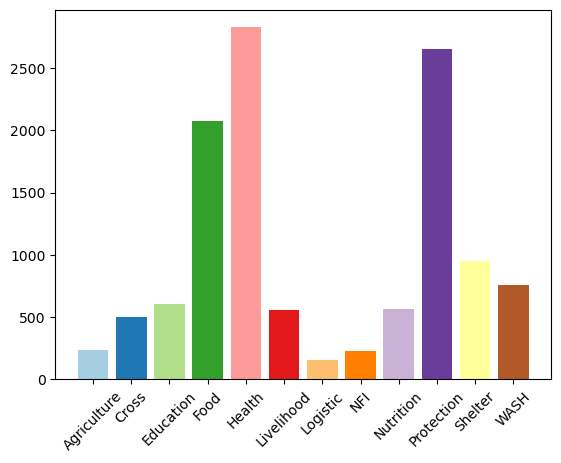

In [13]:
# show a random sample of training data
labels = pd.read_csv(f"{data_path}/thedeep.labels.txt",names = ["label"], usecols = [1],header = None)
sample = df_train.sample()
sample["label"] = labels.loc[sample["label"]].values

print("Random sample drawn from the dataset:\n",
      "Original text", sample["text"].values[0],
      "Cleaned text:",sample["cleaned_text"].values[0],
      "Tokens:",sample["tokens"].values[0],
      "Label:",sample["label"].values[0],sep = "\n")

# plot the label distribution
counts_df = pd.DataFrame(df_train["label"].value_counts()).sort_index()
#counts_df.plot(kind = "bar",legend = False,colormap="Paired")
plt.bar(range(len(counts_df["label"])),counts_df["label"],color = plt.cm.Paired(np.arange(len(counts_df["label"]))))
plt.xticks(ticks = range(0,len(counts_df["label"])),labels = labels["label"].values.tolist(),rotation = 45)
plt.show()

### Mapping word embeddings to dictionary words
Now that we have defined our vocabulary, we need the embedding for each word. We will go through our dictionary and map every word to its vector, and create a new vector if GloVe does not have an embedding for a given word.

In [14]:
dictionary_embeddings = embeddings_to_words(glove_embeddings, dictionary)

random vector created for belowaverage
random vector created for sudans
random vector created for fiveyear
random vector created for [oov]


### Document embedding as the average of word embeddings

Since we will deal with documents, we will have multiple word embeddings for one sample. To be able to represent a document with a single vector, we will define the document embedding as the average of the word embeddings of that document

In [15]:
def embed(tokens):
    """create the document embedding by averaging the word embeddings."""
    
    # get a list of embeddings for each token in dataset
    # if token is in embedding/word mapping, use embedding, else use OOV embedding
    embeddings = [dictionary_embeddings[token] \
    if token in dictionary["index"].values \
    else dictionary_embeddings[OOV_TOKEN] \
    for token in tokens ]

    # take average over all embedding features in a document
    # resulting shape is n_features
    avg = np.average(embeddings, axis=0)

    return avg


In [16]:
# apply the document embedding on the dataset
df_train["embedding"] = df_train["tokens"].apply(embed)
df_test["embedding"] = df_test["tokens"].apply(embed)


In [17]:
df_train

,id,text,label,cleaned_text,tokens,embedding
0,5446,In addition to the immediate life-saving inter...,9,in addition to the immediate lifesaving interv...,"[addition, immediate, lifesaving, intervention...","[-0.5428257490165782, -0.21152858210282385, 0...."
1,8812,There are approximately 2.6 million people cla...,3,there are approximately million people classi...,"[approximately, million, people, classified, p...","[-0.8866645688681918, -0.2827463646385731, 0.3..."
2,16709,"While aid imports have held up recently, comme...",5,while aid imports have held up recently commer...,"[aid, imports, held, recently, commercial, foo...","[-1.5792300950182583, -0.4905391878935301, 0.2..."
3,3526,Heavy rainfalls as well as onrush of water fro...,0,heavy rainfalls as well as onrush of water fro...,"[heavy, rainfalls, well, onrush, water, upstre...","[-1.720515983536286, -0.4157392137071264, 0.37..."
4,4928,"Based on field reports 9 , the main production...",3,based on field reports the main production c...,"[based, field, reports, main, production, chal...","[-1.4746817755779078, -0.40776471944325043, 0...."
...,...,...,...,...,...,...
12105,12744,The total gap in the number of people who requ...,8,the total gap in the number of people who requ...,"[total, gap, number, people, require, assistan...","[0.007283274547157793, -0.04389710236417521, 0..."
12106,9655,A food crisis is looming in the country with t...,0,a food crisis is looming in the country with t...,"[food, crisis, looming, country, seasons, maiz...","[-1.4251434295459626, -0.459614833751158, 0.33..."
12107,6963,? Acute watery diarrhoea (AWD) continues to be...,4,acute watery diarrhoea awd continues to be re...,"[acute, watery, diarrhoea, awd, continues, rep...","[-0.01920851326963919, -0.23690450171717434, 0..."
12108,923,As South India grapples with drought and water...,11,as south india grapples with drought and water...,"[south, india, grapples, drought, water, short...","[-2.11571153610272, -0.46721912133317595, 0.43..."


### Training the Classifiers
Now we are ready to train a classifier. First we prepare the data such that the input is an array of shape (samples, features). Then we go over a list of models, training each classifier with the training data and evaluating it on the test data. Finally, we plot the results.

In [18]:
from Training import clf_train_loop

In [19]:
# Define models
models = {
    "knn1":    {
        "model": KNeighborsClassifier(n_neighbors=1),
        "score" : None,
        },
    "knn2":    {
        "model": KNeighborsClassifier(n_neighbors=2),
        "score" : None,
        },
    "knn3":    {
        "model": KNeighborsClassifier(n_neighbors=3),
        "score" : None,
        },
    "knn5":    {
        "model": KNeighborsClassifier(n_neighbors=5),
        "score" : None,
        },
    "knn11":    {
        "model": KNeighborsClassifier(n_neighbors=11),
        "score" : None,
        },
    "knn21":    {
        "model": KNeighborsClassifier(n_neighbors=21),
        "score" : None,
        },
    "SVC_025":    {
        "model": SVC(kernel="linear", C=0.025),
        "score" : None,
        },
    "SVC_g2c1":    {
        "model": SVC(gamma=2, C=1),
        "score" : None,
        },
    "MLP":    {
        "model": MLPClassifier(alpha=1, max_iter=1000),
        "score" : None,
        },
    "AdaBoost" : {
        "model": AdaBoostClassifier(),
        "score" : None,
        },
    "NaiveBayes" : {
        "model": GaussianNB(),
        "score" : None,
        },

    }

(12110, 50) (12110,)
(2595, 50) (2595,)
loaded knn1 from pickle
loaded knn2 from pickle
loaded knn3 from pickle
loaded knn5 from pickle
loaded knn11 from pickle
loaded knn21 from pickle
loaded SVC_025 from pickle
loaded SVC_g2c1 from pickle
loaded MLP from pickle
loaded AdaBoost from pickle
loaded NaiveBayes from pickle


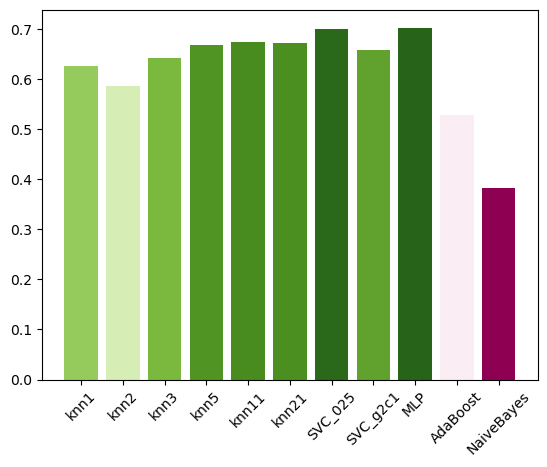

In [20]:
clf_train_loop(models,df_train,df_test)

## PyTorch Classifier

Let us build yet another classifier for predicting the document classes. The classifier will differ from the previous ones slightly, as the embeddings will be updated during the training procedure. The NLP_dictionary class will help us use the Torch.nn.Embedding functionality by mapping words to indices and by resizing samples to same length; samples that are longer than max_length will be capped, samples that are too short will be padded with OOV tokens.

In [21]:
from Classification_average_model import NLP_Dictionary,prepare_batching_data,batch_generator, create_embedding_matrix

nlp_dict = NLP_Dictionary(dictionary, OOV_TOKEN)

### Data batching

Now we will process and generate the data batches. The processing part take in a dataset, maps the words from each sample to the embedding ids and resizes each sample to max_document_length. The batch generation part is essentially a pytorch dataloader: it takes in a dataset and batches it, yielding one batch at a time.

In [22]:
maxlen=9
batch_size=16

# test functionality
data, labels = prepare_batching_data(
    dictionary = nlp_dict,
    data=data_dict["train"]["tokens"][:100],
    labels=data_dict["train"]["label"][:100],
    max_document_length=maxlen,
    padding_token="heyho"
)

print(data.shape, labels.shape)

for idx, x, y in batch_generator(data, labels, batch_size):
    n, feat = x.shape
    assert n <= batch_size
    assert feat == maxlen, (maxlen, feat)

torch.Size([100, 9]) torch.Size([100])


### Embedding Matrix
Now we will define an embedding matrix that maps our dictionary words to indices

In [23]:
embedding_matrix = create_embedding_matrix(glove_embeddings,dictionary)

Dimensionality of the Embeddings: (50,)
random vector created for belowaverage
random vector created for sudans
random vector created for fiveyear
random vector created for [oov]


In [24]:
# make sure that the embeddings are actually correct. 
# go through every dict entry. Access embedding at the same id
# get vectors from original glove and from embedding
# compare, except where word is not in glove
for i in range(len(dictionary)):
    idx = torch.tensor([i])
    vec = embedding_matrix(idx)
    word = dictionary.iloc[i]["index"]
    try:
        vec2 = torch.tensor(glove_embeddings[word])
    except:
        print(word)
        continue
    assert torch.all(vec == vec2)

belowaverage
sudans
fiveyear
[oov]


### Classification Average Model

Now we will define our classifier class. The model consists of an embedding lookup part and a linear mapping part. Both the weights of the linear layer and the embedding vectors are updated during the training procedure.

In [25]:
from Classification_average_model import ClassificationAverageModel, evaluate, update, accuracy

### PyTorch Training Procedure

In [26]:
# instantiate model
model = ClassificationAverageModel(
    embeddings = embedding_matrix,
    document_dim = list(glove_embeddings.values())[0].shape[0],
    num_classes=len(data_dict["label_encoding"])
).to(device)

# check number of parameters
print(f"Number of trainable parameters : {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# check layers
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

# set attribute device, needed for fwd pass
model.device = next(model.parameters()).device

# loss function
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Number of trainable parameters : 48262
embeddings torch.Size([953, 50])
linear.weight torch.Size([12, 50])
linear.bias torch.Size([12])


In [27]:
# hyperparameters for batching
max_document_length = 50
padding_token= OOV_TOKEN


data, labels = prepare_batching_data(
    dictionary = nlp_dict,
    data=data_dict["train"]["tokens"],#[:n],
    labels=data_dict["train"]["label"],#[:n],
    max_document_length=max_document_length,
    padding_token=padding_token
)

vdata, vlabels = prepare_batching_data(
    dictionary = nlp_dict,
    data=data_dict["validation"]["tokens"],#[:n],
    labels=data_dict["validation"]["label"],#[:n],
    max_document_length=max_document_length,
    padding_token=padding_token
)

In [28]:
%load_ext tensorboard
%tensorboard --logdir runs/

In [29]:
epochs = 60
batch_size = 32
batches = int(len(data)/batch_size)+1

early_stop = 4 # 5 consecutive non-improvements
train_errs = []
accs = []

counter = 0
best_acc = 0
n_iter=1
writer = SummaryWriter()


# Evaluate untrained model
acc = evaluate(
    model, 
    batch_generator(vdata, vlabels, batch_size),
    accuracy
    )

avg_acc = torch.mean(acc)
writer.add_scalar('Accuracy/validation', avg_acc, 0)
print(f"initial accuracy: {avg_acc:.2f}")
accs.append(avg_acc)


# TRAIN
for epoch in range(1, epochs+1):

    print(f"epoch: {epoch}/{epochs}", end=" ")

    # update the model 
    errs = update(
        model, 
        batch_generator(data, labels, batch_size),
        criterion, 
        optimizer
    )

    # save and print the average error over this epoch
    avg_err = torch.mean(errs)
    writer.add_scalar('Loss/train', avg_err, epoch)
    print(f"train_error_avg: {avg_err:.2f}", end=" ")
    train_errs.append(avg_err)


    # evaluate the accuracy on the valiadtion set
    acc = evaluate(
        model, 
        batch_generator(vdata, vlabels, batch_size),
        accuracy
        )

    # calculate mean acc over epoch
    avg_acc = torch.mean(acc)

    # log in the tensorboard
    writer.add_scalar('Accuracy/validation', avg_acc, epoch)

    # if better than before -> save model
    if avg_acc > best_acc:
      #save model
      torch.save(model, model_path)
      best_acc = avg_acc
      counter = 0

    # else increase a counter
    else:
      counter +=1
    
    # when too many non-improvements follow directly, early stopping is triggered
    if counter == early_stop:
      break
      
    print(f"accuracy: {avg_acc:.2f}")
    accs.append(avg_acc)


# complete logging.
writer.flush()
writer.close()

initial accuracy: 0.10
epoch: 1/60 train_error_avg: 2.34 accuracy: 0.37
epoch: 2/60 train_error_avg: 2.26 accuracy: 0.46
epoch: 3/60 train_error_avg: 2.18 accuracy: 0.51
epoch: 4/60 train_error_avg: 2.14 accuracy: 0.54
epoch: 5/60 train_error_avg: 2.11 accuracy: 0.55
epoch: 6/60 train_error_avg: 2.09 accuracy: 0.56
epoch: 7/60 train_error_avg: 2.08 accuracy: 0.57
epoch: 8/60 train_error_avg: 2.07 accuracy: 0.57
epoch: 9/60 train_error_avg: 2.06 accuracy: 0.57
epoch: 10/60 train_error_avg: 2.06 accuracy: 0.57
epoch: 11/60 train_error_avg: 2.05 accuracy: 0.58
epoch: 12/60 train_error_avg: 2.05 accuracy: 0.58
epoch: 13/60 train_error_avg: 2.04 accuracy: 0.59
epoch: 14/60 train_error_avg: 2.03 accuracy: 0.59
epoch: 15/60 train_error_avg: 2.03 accuracy: 0.60
epoch: 16/60 train_error_avg: 2.02 accuracy: 0.60
epoch: 17/60 train_error_avg: 2.02 accuracy: 0.60
epoch: 18/60 train_error_avg: 2.01 accuracy: 0.60
epoch: 19/60 train_error_avg: 2.01 accuracy: 0.61
epoch: 20/60 train_error_avg: 2.00 a

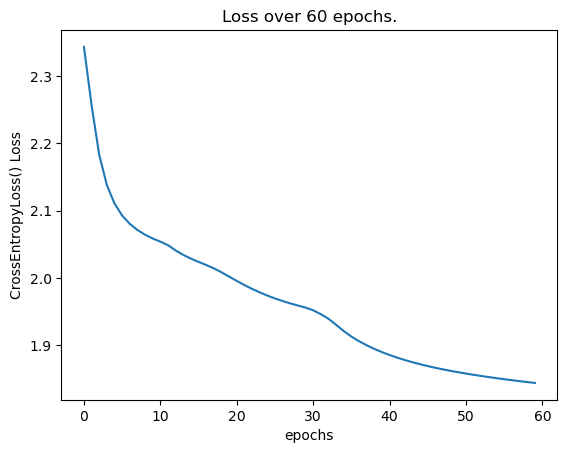

Text(0, 0.5, 'Accuracy')

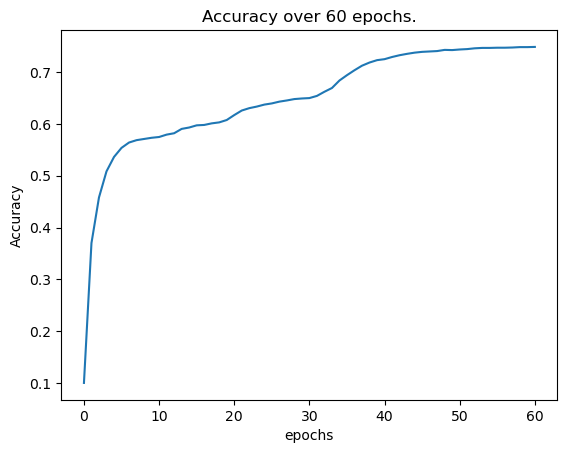

In [30]:
plt.plot(train_errs)
plt.title(f"Loss over {epochs} epochs.")
plt.xlabel("epochs")
plt.ylabel(f"{criterion} Loss")
plt.show()

plt.plot(accs)
plt.title(f"Accuracy over {epochs} epochs.")
plt.xlabel("epochs")
plt.ylabel(f"Accuracy")

In [31]:
best_model = torch.load(model_path)

# precompute batchin data
tdata, tlabels = prepare_batching_data(
    dictionary = nlp_dict,
    data=data_dict["test"]["tokens"],#[:n],
    labels=data_dict["test"]["label"],#[:n],
    max_document_length=max_document_length,
    padding_token=padding_token
)

### Final Model Evaluation

In [32]:
acc = evaluate(
    best_model, 
    batch_generator(tdata, tlabels, batch_size),
    accuracy
    )
    
best_model_test_acc = torch.mean(acc)

acc = evaluate(
    best_model, 
    batch_generator(vdata, vlabels, batch_size),
    accuracy
    )

best_model_valid_acc = torch.mean(acc)

acc = evaluate(
    best_model, 
    batch_generator(data, labels, batch_size),
    accuracy
    )

best_model_train_acc = torch.mean(acc)

In [33]:
print(
    f"The best Model after 56 training epochs with a maximum "
    f"Document length of {max_document_length}\nreached a test accuracy of {100*best_model_test_acc:.2f}%\n"
    f"validation accuracy of {100*best_model_valid_acc:.2f}%\n"
    f"training accuracy of {100*best_model_train_acc:.2f}%"
    )

The best Model after 56 training epochs with a maximum Document length of 50
reached a test accuracy of 75.13%
validation accuracy of 74.85%
training accuracy of 79.17%


### Example Predictions

In [34]:
model.eval()
device = model.device

data_dict["test"]["tokens"]
data_dict["test"]["label"]

n = 10
for i, x, y in batch_generator(tdata, tlabels, batch_size=1):
    x, y = x.to(device), y.to(device)
    predicted_label = model.predict(x).item()
    print(" ".join(data_dict["test"]["tokens"][i-1]))
    actual_label = data_dict["test"]["label"][i-1]
    
    print("predicted: ", data_dict["label_encoding"].iloc[predicted_label].item())
    print("actual: ", data_dict["label_encoding"].iloc[actual_label].item())
    print()

    if i == n:
      break

overall decrease mam children admissions april april
predicted:  Health
actual:  Nutrition

fear ebola also led attacks health workers april angry crowd attacked ebola treatment center macenta kilometers southeast guineas capital conakry run doctors without borders medecins sans frontieres msf accused bringing ebola city august people nzérékoré guineas second largest city protested spraying market disinfectant believed infected ebola virus rioted injuring people including security forces law enforcement agencies congo ensure quickly adequately appropriately respond similar attacks occur
predicted:  Health
actual:  Protection

wheat staple food afghans comprising percent diet lowquality rice poor sometimes necessary substitute markets represent significant population centers consumer markets kabul capital supplies central provinces transit point north south east west jalalabad supplies eastern part country acts crossborder market pakistan mazaresarif supplies northern provinces good yea